## Predicción de Retornos de BTC usando Modelos GBM

Este notebook aplica la misma metodología de pruebas exhaustivas del modelo VAR pero usando **Geometric Brownian Motion (GBM)** como modelo base.

### Enfoque GBM Adaptado

**GBM Básico**: Modela retornos usando deriva (μ) y volatilidad (σ) constantes estimados de datos históricos. La predicción es simplemente la deriva media.

**GBM Multivariado**: En este contexto, usamos una **Regresión Lineal** para predecir `btc_log_return` usando variables adicionales como predictores. Este enfoque nos permite incorporar información exógena, de forma análoga a VARMAX.

### Variables y Combinaciones

Probamos las mismas combinaciones que en el notebook de VAR para mantener la comparabilidad.

| Modelo                                            | Variables                                                                   |
| ------------------------------------------------- | --------------------------------------------------------------------------- |
| **btc_log_return (GBM Básico)**                   | `btc_log_return`                                                            |
| **btc + sp500**                                   | `btc_log_return`, `sp500_log_return`                                        |
| **btc + sp500 + fear_greed**                      | `btc_log_return`, `sp500_log_return`, `fear_greed`                          |
| **btc + btc_rsi**                                 | `btc_log_return`, `btc_rsi`                                                 |
| **btc + fear_greed**                              | `btc_log_return`, `btc_rsi`, `fear_greed`                                   |
| **btc + trend_diff**                              | `btc_log_return`, `trend_diff`                                              |
| **btc + btc_rsi + active_addresses**              | `btc_log_return`, `btc_rsi`, `active_addresses_pct_change`                  |
| **btc + fear_greed + active + rsi**               | `btc_log_return`, `fear_greed`, `active_addresses`, `btc_rsi`               |

### Metodología

Para cada conjunto de variables:
- Identificamos la variable objetivo (`btc_log_return`) y las variables predictoras.
- Si no hay predictores, ajustamos un modelo **GBM Básico**.
- Si hay predictores, ajustamos un modelo de **Regresión Lineal**.
- Dividimos datos en entrenamiento (80%) y testeo (20%).
- Realizamos pronósticos en el período de testeo.
- Evaluamos el error de predicción con **MAE** y **RMSE** y graficamos resultados para `btc_log_return` y el precio reconstruido.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import optuna

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

/Users/agustindelavega/.pyenv/versions/3.10.14/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
endogenous = {"btc_log_return","btc_rsi","sp500_log_return","gold_log_return",
        "dxy_log_return","eth_log_return","trend_diff","trend"}

In [5]:
def fecha_inicio(vars_):
    if "fear_greed" in vars_:
        return "2018-02-01"
    if "eth_log_return"  in vars_:
        return "2017-11-09"
    return "2014-09-17"

In [6]:
def split_target_predictors(vars_):
    """Separa variable objetivo de predictores para GBM"""
    target = "btc_log_return"
    predictors = [v for v in vars_ if v != target]
    return target, predictors

In [20]:
def load_window(df, target, predictors):
    start = fecha_inicio([target] + predictors)
    
    # Cargar variable objetivo
    Y = df.loc[start:, target].dropna()
    
    # Cargar predictores si existen
    if predictors:
        X = df.loc[Y.index, predictors].bfill()
        # Eliminar filas donde falten predictores
        valid_idx = X.dropna().index
        Y = Y.loc[valid_idx]
        X = X.loc[valid_idx]
    else:
        X = None
    
    return Y, X

In [21]:
def calculate_gbm_parameters(returns, drift_adjustment=0.5):
    """
    Calcular parámetros μ y σ para Geometric Brownian Motion
    
    Args:
        returns: Serie de retornos logarítmicos
        window_days: Ventana de días para calcular parámetros (None = todos los datos)
        drift_adjustment: Factor de ajuste para la deriva (0.5 * variance por defecto)
    
    Returns:
        mu, sigma: Parámetros del GBM
    """
    returns_window = returns
    
    # Calcular volatilidad (σ)
    sigma = returns_window.std()
    
    # Calcular deriva (μ) con ajuste por varianza
    mean_return = returns_window.mean()
    variance = returns_window.var()
    mu = mean_return + drift_adjustment * variance
    
    return mu, sigma


In [22]:
def optimize_gbm_parameters(Y_train, Y_test, btc_close, n_trials=30):
    """Optimizar parámetros del Geometric Brownian Motion usando Optuna"""
    
    def objective(trial):
        # Parámetros a optimizar para GBM financiero
        drift_adjustment = trial.suggest_float('drift_adjustment', 0.0, 1.0)
        
        # Calcular parámetros GBM con la configuración propuesta
        mu, sigma = calculate_gbm_parameters(Y_train, drift_adjustment)
        
        # Generar predicciones (deriva constante como en GBM básico)
        predictions = np.full(len(Y_test), mu)
        
        # Calcular RMSE en escala de precio
        try:
            # Obtener precio base (último precio antes del período de test)
            p0 = btc_close.loc[Y_test.index[0] - pd.Timedelta(days=1)]
            
            # Reconstruir precios
            real_prices = reconstruct_price(Y_test, p0)
            pred_prices = reconstruct_price(predictions, p0)
            
            # Calcular RMSE de precios
            rmse_price = mean_squared_error(real_prices, pred_prices)**0.5
            return rmse_price
        except:
            # Si hay error en la reconstrucción, usar RMSE de retornos
            return mean_squared_error(Y_test, predictions)**0.5
    
    # Ejecutar optimización
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    print(f"🔍 Mejores parámetros para GBM:")
    for key, value in study.best_params.items():
        print(f"   {key}: {value}")
    print(f"📊 Mejor RMSE en escala de precio: ${study.best_value:,.2f}")
    
    return study.best_params


In [23]:
def split_train_test(Y, X, split=0.8):
    n_train = int(len(Y) * split)
    Y_tr, Y_te = Y.iloc[:n_train], Y.iloc[n_train:]
    X_tr = X.iloc[:n_train] if X is not None else None
    X_te = X.iloc[n_train:] if X is not None else None
    return Y_tr, Y_te, X_tr, X_te

In [24]:
def fit_model(Y, X, Y_test=None, btc_close=None, optimize_gbm=False):
    if X is not None:
        print("Entrenando Regresión Lineal (GBM Multivariado)")
        model = LinearRegression()
        model.fit(X, Y)
        
        print("\nResumen del modelo:")
        print(f"R² score: {model.score(X, Y):.4f}")
        print(f"Coeficientes: {model.coef_}")
        print(f"Intercepto: {model.intercept_:.6f}")
        
        return {'type': 'multivariate', 'model': model}
    else:
        if optimize_gbm and btc_close is not None and Y_test is not None:
            print("Optimizando parámetros del Geometric Brownian Motion con Optuna")
            
            # Optimizar parámetros μ y σ del GBM
            best_params = optimize_gbm_parameters(Y, Y_test, btc_close)
            
            # Calcular parámetros finales con la configuración óptima
            mu, sigma = calculate_gbm_parameters(
                Y, 
                drift_adjustment=best_params['drift_adjustment']
            )
            
            print(f"\nGBM Optimizado - Parámetros finales:")
            print(f"μ (deriva): {mu:.6f}")
            print(f"σ (volatilidad): {sigma:.6f}")
            print(f"Ajuste de deriva: {best_params['drift_adjustment']:.3f}")
            
            return {
                'type': 'gbm_optimized', 
                'mu': mu, 
                'sigma': sigma,
                'best_params': best_params
            }
        else:
            print("Entrenando GBM Básico")
            mu = Y.mean() + 0.5 * Y.var()  # deriva ajustada
            sigma = Y.std()  # volatilidad
            
            print("\nResumen del modelo:")
            print(f"μ (deriva): {mu:.6f}")
            print(f"σ (volatilidad): {sigma:.6f}")
            
            return {'type': 'basic', 'mu': mu, 'sigma': sigma}

In [25]:
def reconstruct_price(returns, p0):
    price = [p0]
    for r in returns: price.append(price[-1]*np.exp(r))
    return price[1:]

In [26]:
def eval_and_plot(model_dict, Y_te, X_te, btc_close, nombre):
    try:
        if model_dict['type'] == 'multivariate':
            print("Prediciendo con Regresión Lineal")
            predictions = model_dict['model'].predict(X_te)
            predictions = pd.Series(predictions, index=Y_te.index)
        elif model_dict['type'] == 'gbm_optimized':
            print("Prediciendo con GBM Optimizado (Geometric Brownian Motion)")
            # Usar la deriva optimizada como predicción constante
            predictions = np.full(len(Y_te), model_dict['mu'])
            predictions = pd.Series(predictions, index=Y_te.index)
        else:
            print("Prediciendo con GBM Básico")
            predictions = np.full(len(Y_te), model_dict['mu'])
            predictions = pd.Series(predictions, index=Y_te.index)
        
    except Exception as e:
        print("❌ Error en forecasting:", e)
        return

    # Calcular métricas de retornos
    mae_ret = mean_absolute_error(Y_te, predictions)
    rmse_ret = mean_squared_error(Y_te, predictions)**0.5
    
    print(f"\n📊 Métricas de Retornos:")
    print(f"   MAE:  {mae_ret:.6f}")
    print(f"   RMSE: {rmse_ret:.6f}")

    # gráfico retornos
    plt.figure(figsize=(12,4))
    plt.plot(Y_te.index, Y_te, label='Real', linewidth=2)
    plt.plot(predictions.index, predictions,'--',label='Predicción', linewidth=2)
    plt.title(f"Retorno log BTC - Modelo: {nombre}")
    plt.ylabel('Log Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Reconstruir precios
    try:
        # precio base = último precio real antes del test
        p0 = btc_close.loc[Y_te.index[0]-pd.Timedelta(days=1)]
        real_p = reconstruct_price(Y_te, p0)
        pred_p = reconstruct_price(predictions, p0)
        
        # Calcular métricas de precios
        mae_price = mean_absolute_error(real_p, pred_p)
        rmse_price = mean_squared_error(real_p, pred_p)**0.5
        
        print(f"\n📊 Métricas de Precios:")
        print(f"   MAE:  ${mae_price:,.2f}")
        print(f"   RMSE: ${rmse_price:,.2f}")

        plt.figure(figsize=(12,4))
        plt.plot(Y_te.index, real_p, label='Precio real', linewidth=2)
        plt.plot(Y_te.index, pred_p,'--',label='Precio predicho', linewidth=2)
        plt.title(f"Precio BTC - Modelo: {nombre}")
        plt.ylabel('Precio (USD)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"❌ Error reconstruyendo precios: {e}")
        mae_price = rmse_price = np.nan

    # Para modelos GBM/Regresión no tenemos AIC/BIC como en statsmodels
    return {
        "mae_ret": mae_ret, 
        "rmse_ret": rmse_ret, 
        "mae_price": mae_price, 
        "rmse_price": rmse_price, 
        "aic": np.nan, 
        "bic": np.nan
    }

In [27]:
df = pd.read_csv("../datasets/merged/master_improved.csv", index_col=0, parse_dates=True)
if 'btc_close' not in df.columns:
    raise KeyError("Se requiere la columna 'btc_close' en el DataFrame.")
df = df.asfreq('D')

In [28]:
modelos = {
    "GBM Básico": ["btc_log_return"],
    "btc + sp500" : ["btc_log_return","sp500_log_return"],
    "btc + sp500 + fear_greed" : ["btc_log_return","sp500_log_return","fear_greed"],
    "btc + btc_rsi" : ["btc_log_return","btc_rsi"],
    "btc + fear_greed": ["btc_log_return","btc_rsi","fear_greed"],
    "btc + trend_diff": ["btc_log_return","trend_diff"],
    "btc + btc_rsi + active_addreses": ["btc_log_return","btc_rsi","active_addresses_pct_change"],
    "btc + fear_greed + active + rsi": ["btc_log_return","fear_greed","active_addresses","btc_rsi"]
}


🔍 MODELO: GBM Básico
Optimizando parámetros del Geometric Brownian Motion con Optuna
🔍 Mejores parámetros para GBM:
   drift_adjustment: 0.3243720147156677
📊 Mejor RMSE en escala de precio: $9,414.70

GBM Optimizado - Parámetros finales:
μ (deriva): 0.001785
σ (volatilidad): 0.038323
Ajuste de deriva: 0.324
Prediciendo con GBM Optimizado (Geometric Brownian Motion)

📊 Métricas de Retornos:
   MAE:  0.017579
   RMSE: 0.024995


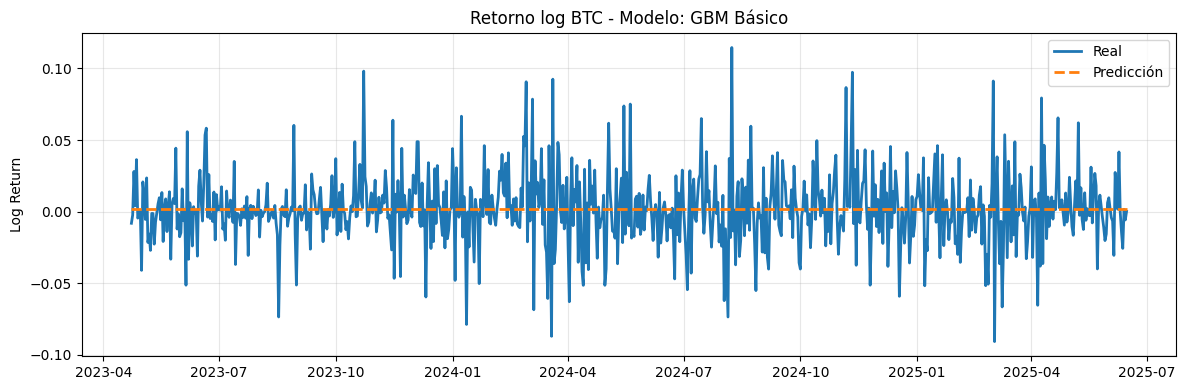


📊 Métricas de Precios:
   MAE:  $7,645.32
   RMSE: $9,414.70


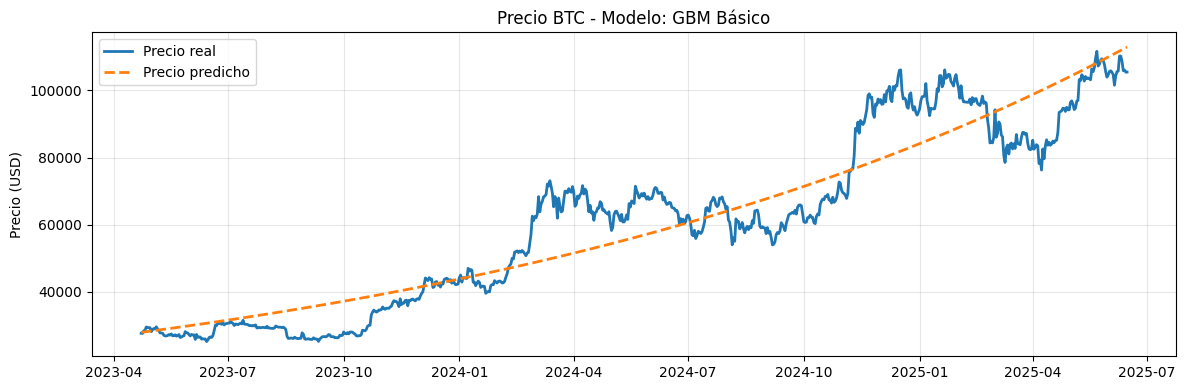



🔍 MODELO: btc + sp500
Entrenando Regresión Lineal (GBM Multivariado)

Resumen del modelo:
R² score: 0.0407
Coeficientes: [0.79155477]
Intercepto: 0.001126
Prediciendo con Regresión Lineal

📊 Métricas de Retornos:
   MAE:  0.017021
   RMSE: 0.024043


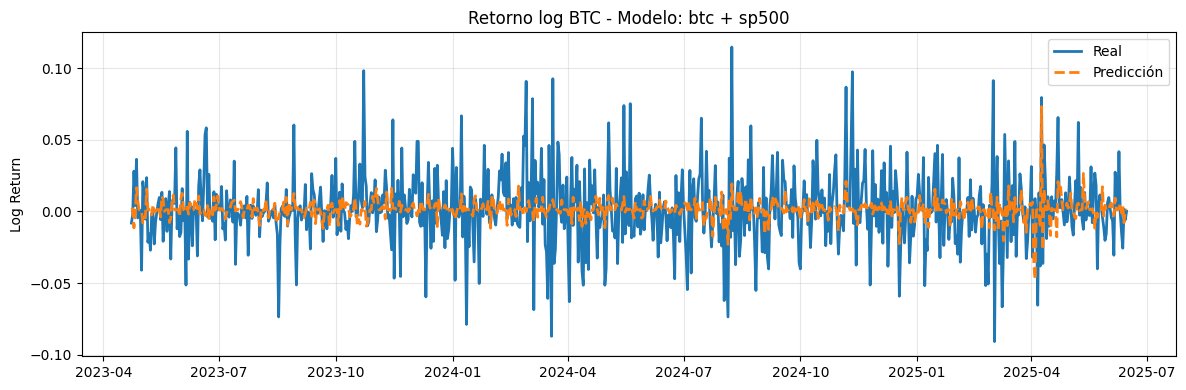


📊 Métricas de Precios:
   MAE:  $9,015.11
   RMSE: $12,004.44


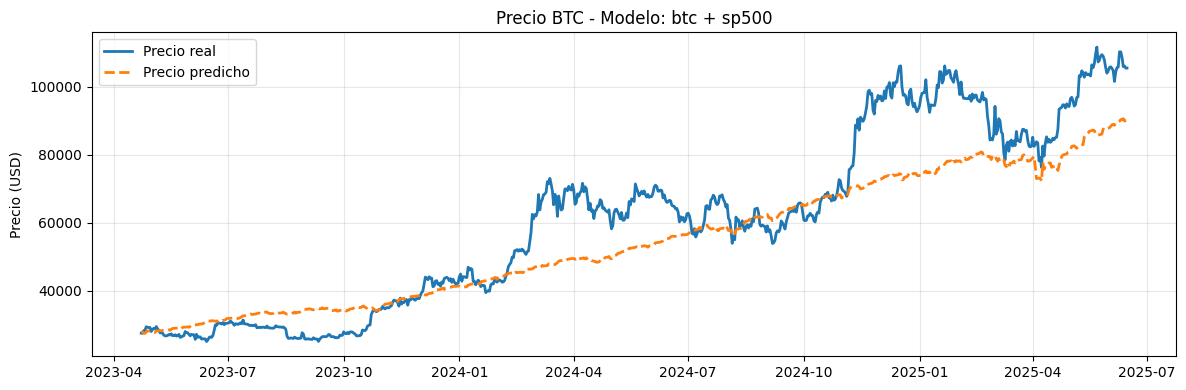



🔍 MODELO: btc + sp500 + fear_greed
Entrenando Regresión Lineal (GBM Multivariado)

Resumen del modelo:
R² score: 0.0803
Coeficientes: [9.22445541e-01 7.84579839e-05]
Intercepto: -0.003012
Prediciendo con Regresión Lineal

📊 Métricas de Retornos:
   MAE:  0.018862
   RMSE: 0.025654


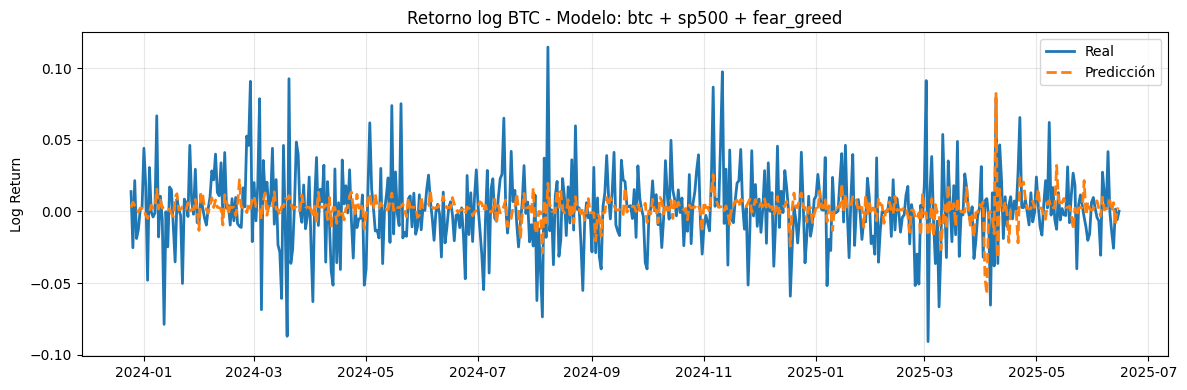


📊 Métricas de Precios:
   MAE:  $14,280.41
   RMSE: $17,021.50


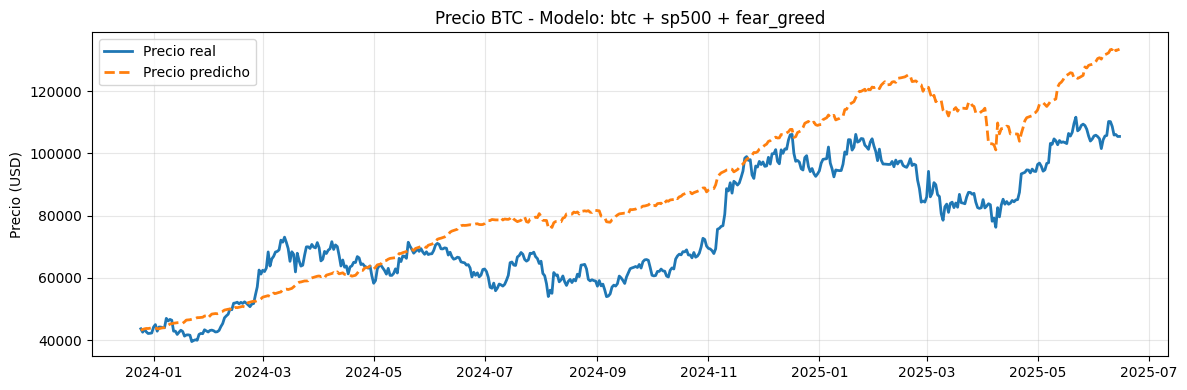



🔍 MODELO: btc + btc_rsi
Entrenando Regresión Lineal (GBM Multivariado)

Resumen del modelo:
R² score: 0.0763
Coeficientes: [0.00057]
Intercepto: -0.029267
Prediciendo con Regresión Lineal

📊 Métricas de Retornos:
   MAE:  0.018087
   RMSE: 0.024294


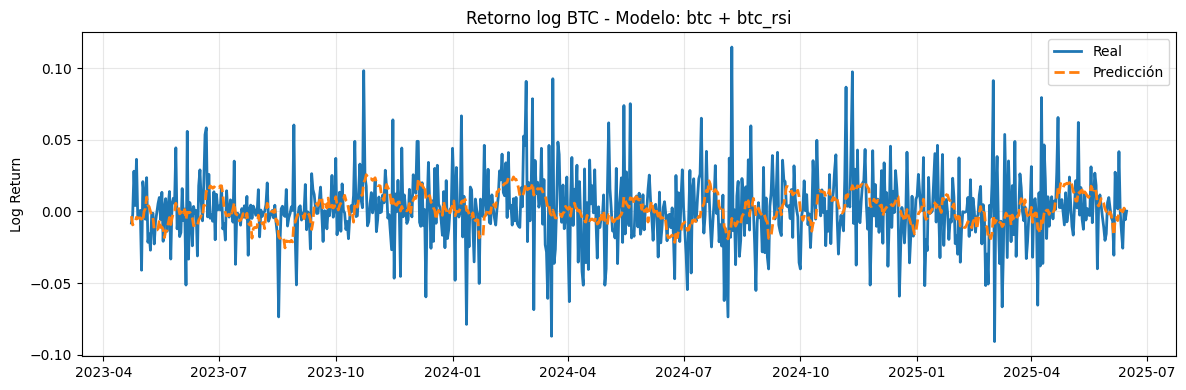


📊 Métricas de Precios:
   MAE:  $7,219.78
   RMSE: $8,610.00


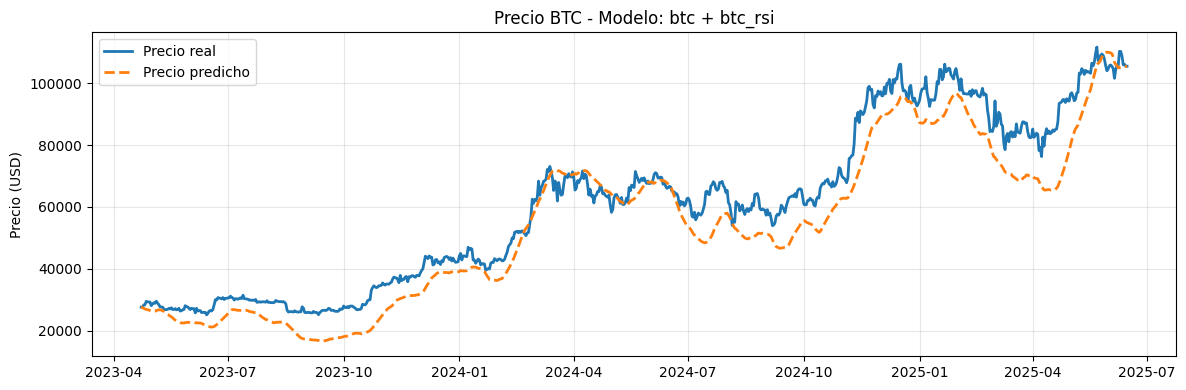



🔍 MODELO: btc + fear_greed
Entrenando Regresión Lineal (GBM Multivariado)

Resumen del modelo:
R² score: 0.0893
Coeficientes: [ 0.00069955 -0.00024389]
Intercepto: -0.024935
Prediciendo con Regresión Lineal

📊 Métricas de Retornos:
   MAE:  0.019107
   RMSE: 0.025474


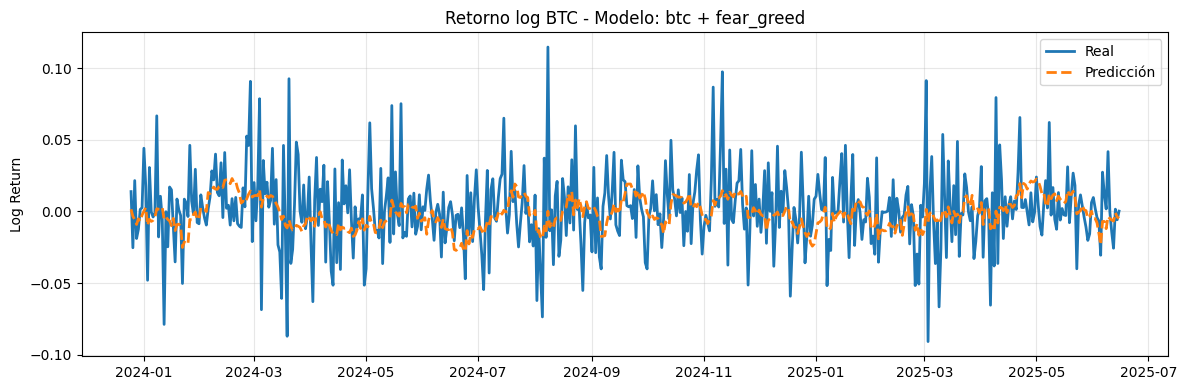


📊 Métricas de Precios:
   MAE:  $47,618.87
   RMSE: $54,217.13


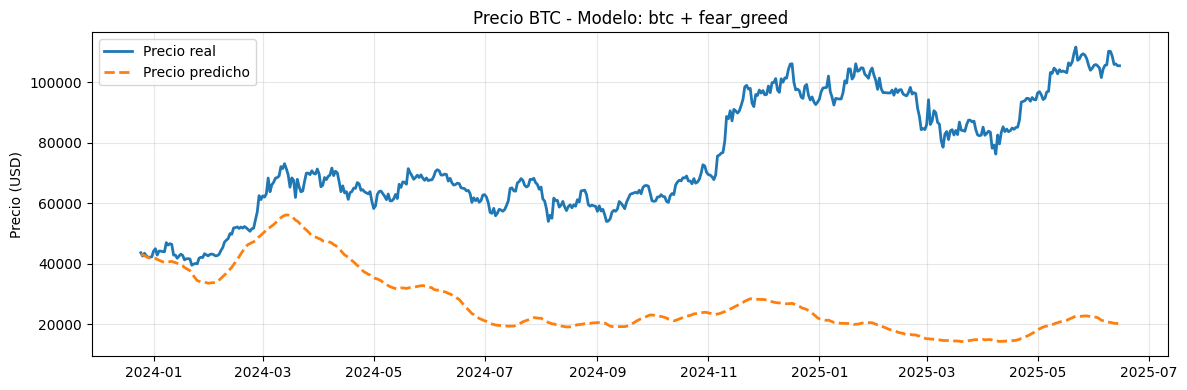



🔍 MODELO: btc + trend_diff
Entrenando Regresión Lineal (GBM Multivariado)

Resumen del modelo:
R² score: 0.0001
Coeficientes: [-8.79033361e-05]
Intercepto: 0.001310
Prediciendo con Regresión Lineal

📊 Métricas de Retornos:
   MAE:  0.017585
   RMSE: 0.025040


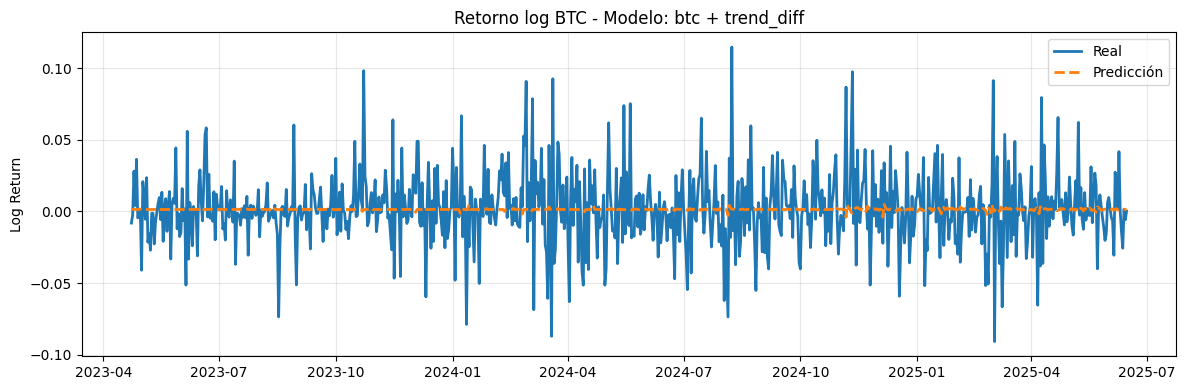


📊 Métricas de Precios:
   MAE:  $13,881.96
   RMSE: $18,150.18


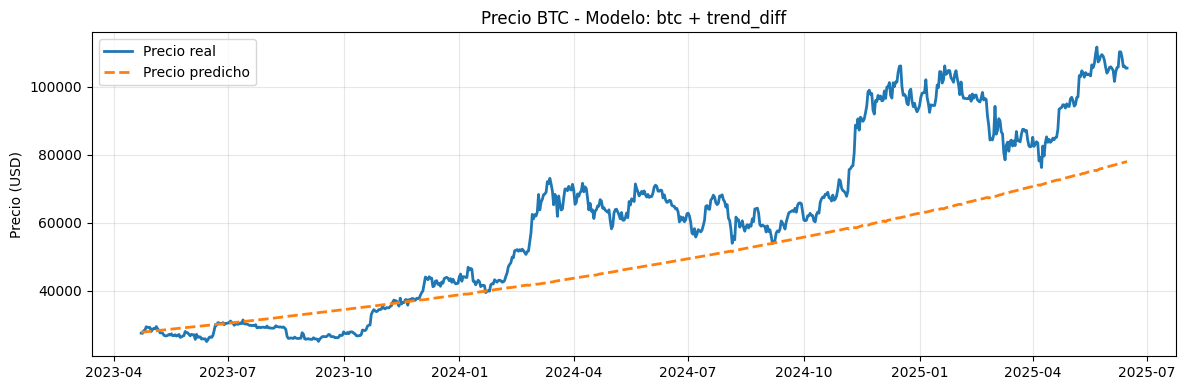



🔍 MODELO: btc + btc_rsi + active_addreses
Entrenando Regresión Lineal (GBM Multivariado)

Resumen del modelo:
R² score: 0.0764
Coeficientes: [0.00056931 0.0051583 ]
Intercepto: -0.029250
Prediciendo con Regresión Lineal

📊 Métricas de Retornos:
   MAE:  0.018088
   RMSE: 0.024293


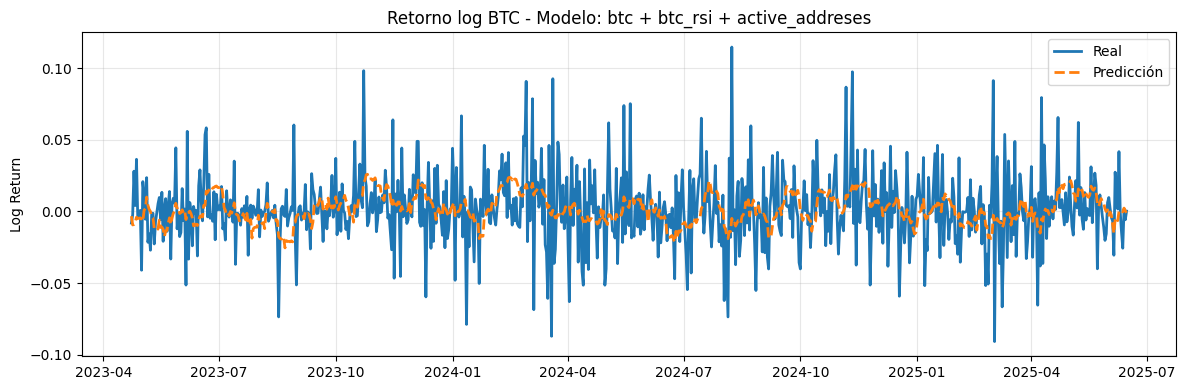


📊 Métricas de Precios:
   MAE:  $7,420.98
   RMSE: $8,845.53


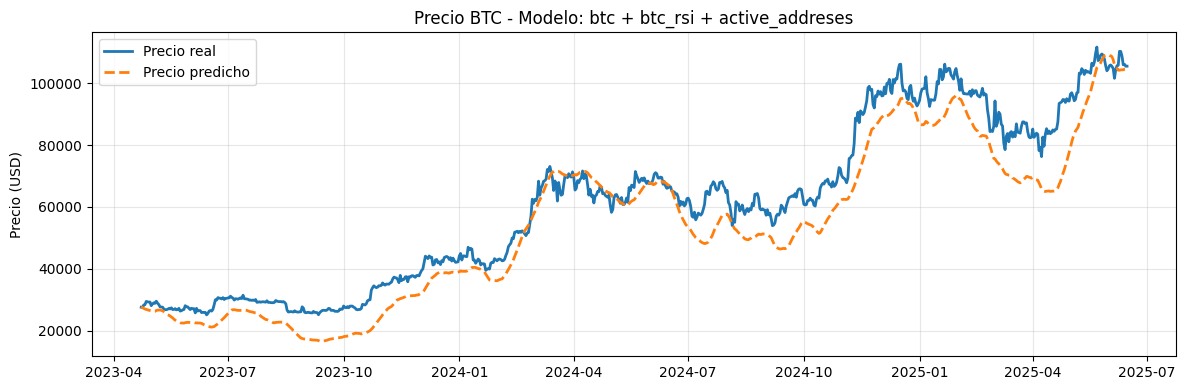



🔍 MODELO: btc + fear_greed + active + rsi
Entrenando Regresión Lineal (GBM Multivariado)

Resumen del modelo:
R² score: 0.0895
Coeficientes: [-2.55197179e-04  4.58295753e-09  7.00849393e-04]
Intercepto: -0.027273
Prediciendo con Regresión Lineal

📊 Métricas de Retornos:
   MAE:  0.019116
   RMSE: 0.025491


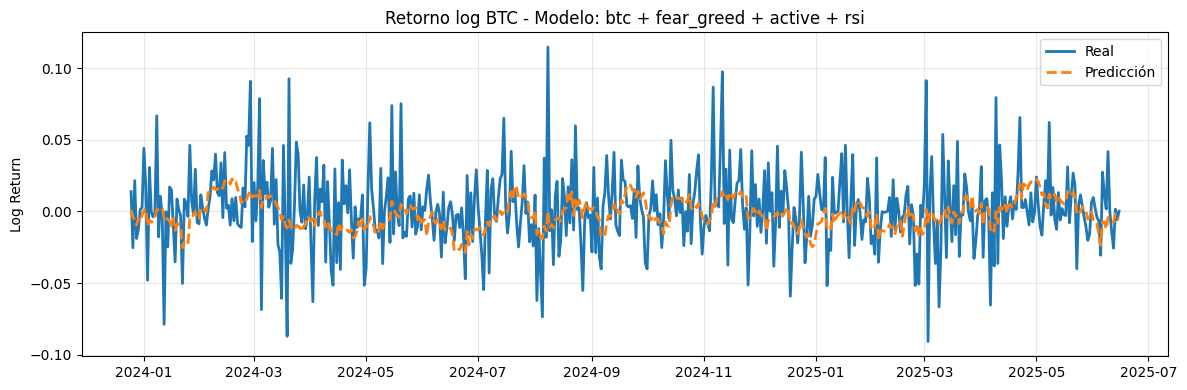


📊 Métricas de Precios:
   MAE:  $49,714.26
   RMSE: $56,644.61


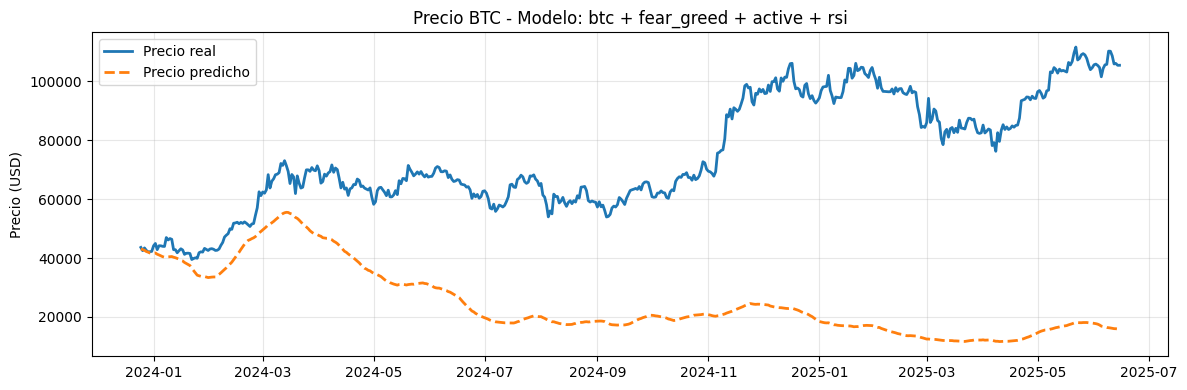

In [29]:
resultados = []

for nombre, vars_ in modelos.items():
    print(f"\n{'='*60}")
    print(f"🔍 MODELO: {nombre}")
    print(f"{'='*60}")
    
    target, predictors = split_target_predictors(vars_)
    Y, X = load_window(df, target, predictors)
    Y_tr, Y_te, X_tr, X_te = split_train_test(Y, X, split=0.8)
    
    # Usar optimización de Optuna solo para el modelo "GBM Básico"
    optimize_gbm = (nombre == "GBM Básico")
    model_dict = fit_model(Y_tr, X_tr, Y_test=Y_te, btc_close=df['btc_close'], optimize_gbm=optimize_gbm)
    resultado = eval_and_plot(model_dict, Y_te, X_te, df['btc_close'], nombre)
    
    if resultado:
        resultado["modelo"] = nombre
        resultados.append(resultado)
        
    print(f"\n{'='*60}")

In [31]:
# Mostrar tabla de resultados
resultados_df = pd.DataFrame(resultados).set_index('modelo')

print("\n" + "="*80)
print("📊 RESUMEN COMPLETO DE RESULTADOS - MODELOS GBM")
print("="*80)

# Formatear la tabla para mejor visualización
resultados_formatted = resultados_df.copy()
resultados_formatted['mae_ret'] = resultados_formatted['mae_ret'].apply(lambda x: f"{x:.6f}")
resultados_formatted['rmse_ret'] = resultados_formatted['rmse_ret'].apply(lambda x: f"{x:.6f}")
resultados_formatted['mae_price'] = resultados_formatted['mae_price'].apply(lambda x: f"${x:,.2f}" if not pd.isna(x) else "N/A")
resultados_formatted['rmse_price'] = resultados_formatted['rmse_price'].apply(lambda x: f"${x:,.2f}" if not pd.isna(x) else "N/A")

display(resultados_formatted[['mae_ret', 'rmse_ret', 'mae_price', 'rmse_price']])

print("\n📈 RANKING POR RMSE DE RETORNOS:")
print("-" * 40)
ranking_ret = resultados_df.sort_values('rmse_ret')[['rmse_ret', 'mae_ret']]
for i, (modelo, row) in enumerate(ranking_ret.iterrows(), 1):
    print(f"{i:2d}. {modelo:<35} RMSE: {row['rmse_ret']:.6f}")

print("\n💰 RANKING POR RMSE DE PRECIOS:")
print("-" * 40)
ranking_price = resultados_df.dropna(subset=['rmse_price']).sort_values('rmse_price')[['rmse_price', 'mae_price']]
for i, (modelo, row) in enumerate(ranking_price.iterrows(), 1):
    print(f"{i:2d}. {modelo:<35} RMSE: ${row['rmse_price']:,.2f}")


📊 RESUMEN COMPLETO DE RESULTADOS - MODELOS GBM


,mae_ret,rmse_ret,mae_price,rmse_price
modelo,,,,
GBM Básico,0.017579,0.024995,"$7,645.32","$9,414.70"
btc + sp500,0.017021,0.024043,"$9,015.11","$12,004.44"
btc + sp500 + fear_greed,0.018862,0.025654,"$14,280.41","$17,021.50"
btc + btc_rsi,0.018087,0.024294,"$7,219.78","$8,610.00"
btc + fear_greed,0.019107,0.025474,"$47,618.87","$54,217.13"
btc + trend_diff,0.017585,0.025040,"$13,881.96","$18,150.18"
btc + btc_rsi + active_addreses,0.018088,0.024293,"$7,420.98","$8,845.53"
btc + fear_greed + active + rsi,0.019116,0.025491,"$49,714.26","$56,644.61"



📈 RANKING POR RMSE DE RETORNOS:
----------------------------------------
 1. btc + sp500                         RMSE: 0.024043
 2. btc + btc_rsi + active_addreses     RMSE: 0.024293
 3. btc + btc_rsi                       RMSE: 0.024294
 4. GBM Básico                          RMSE: 0.024995
 5. btc + trend_diff                    RMSE: 0.025040
 6. btc + fear_greed                    RMSE: 0.025474
 7. btc + fear_greed + active + rsi     RMSE: 0.025491
 8. btc + sp500 + fear_greed            RMSE: 0.025654

💰 RANKING POR RMSE DE PRECIOS:
----------------------------------------
 1. btc + btc_rsi                       RMSE: $8,610.00
 2. btc + btc_rsi + active_addreses     RMSE: $8,845.53
 3. GBM Básico                          RMSE: $9,414.70
 4. btc + sp500                         RMSE: $12,004.44
 5. btc + sp500 + fear_greed            RMSE: $17,021.50
 6. btc + trend_diff                    RMSE: $18,150.18
 7. btc + fear_greed                    RMSE: $54,217.13
 8. btc + fear_gr